In [1]:
import nd2
import os
import tifffile, re


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# generate data organization
import sys
sys.path.append(r'/Users/puzheng/Documents/MERFISH')
import ChromAn
from ChromAn.src.file_io import data_organization
# add 

In [2]:
data_folder = r'/Users/puzheng/Documents/MERFISH/DY'

In [3]:
# load data:

for _fl in os.listdir(data_folder):
    if _fl.split(os.extsep)[-1] == 'nd2':
        print(_fl)
        with nd2.ND2File(os.path.join(data_folder, _fl)) as ndfile:
            print(ndfile.metadata)
            metadata = ndfile.metadata
            im_stack = ndfile.asarray()
            voxel_sizes = ndfile.voxel_size()
        break


20240814_232340_437__Channel60x CY5,60x DSRED,60x GFP_Seq0008 - Denoised.nd2
Metadata(contents=Contents(channelCount=3, frameCount=312), channels=[Channel(channel=ChannelMeta(name='60x CY5', index=0, color=Color(r=255, g=0, b=255, a=1.0), emissionLambdaNm=700.0, excitationLambdaNm=None), loops=LoopIndices(NETimeLoop=None, TimeLoop=None, XYPosLoop=0, ZStackLoop=1), microscope=Microscope(objectiveMagnification=60.0, objectiveName='PLAN APO λD 60x OIL OFN25 DIC N2', objectiveNumericalAperture=1.42, zoomMagnification=1.0, immersionRefractiveIndex=1.515, projectiveMagnification=None, pinholeDiameterUm=50.0, modalityFlags=['fluorescence', 'spinningDiskConfocal']), volume=Volume(axesCalibrated=(True, True, True), axesCalibration=(0.1107206280606, 0.1107206280606, 0.5), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(-0.9999999001902034, 0.00044678807428339995, -0.00044678807428339995, -0.99999990

In [4]:
# output
output_folder = r'/Users/puzheng/Documents/MERFISH/MERFISH_Data/20240914-MF4'
if not os.path.exists(output_folder):
    print(f"Create output folder: {output_folder}")
    os.makedirs(output_folder)

In [5]:
position_df = {'fov':[], 'X':[], 'Y':[], 'Z':[]}
with nd2.ND2File(os.path.join(data_folder, os.listdir(data_folder)[1])) as ndfile:
    for _k, _v in ndfile.unstructured_metadata()['ImageMetadataLV']['SLxExperiment']['LoopPars']['Points'].items():
        #print(_k, _v['PosX'], _v['PosY'], _v['PosZ'])
        position_df['fov'].append(int(_k.split('i')[-1]))
        position_df['X'].append(_v['PosX'])
        position_df['Y'].append(_v['PosY'])
        position_df['Z'].append(_v['PosZ'])
    
    #print(ndfile.attributes)
position_df = pd.DataFrame(position_df).set_index('fov')
# save df
position_df.to_csv(os.path.join(output_folder, 'positions.csv'))
# save x-y position file:
position_df[['X','Y']].to_csv(os.path.join(output_folder, f"{20240914}_positions.txt"), float_format='%.2f', index=False, header=False)

In [6]:
position_df

,X,Y,Z
fov,,,
0,187.7,1883.5,4364.12
1,-67.5,1883.7,4364.12
2,-322.8,1883.7,4364.12
3,-577.6,1883.7,4364.12
4,-832.7,1884.0,4364.10
5,-1087.7,1884.0,4364.08
6,-1087.6,2139.1,4364.12
7,-832.4,2139.1,4364.10
8,-577.4,2139.0,4364.10


In [8]:
# save iamges:
# load data:
data_folder = r'/Users/puzheng/Documents/MERFISH/DY'
for _fl in os.listdir(data_folder):
    if _fl.split(os.extsep)[-1] == 'nd2':
        print(_fl)
        with nd2.ND2File(os.path.join(data_folder, _fl)) as ndfile:
            #print(ndfile.metadata)
            metadata = ndfile.metadata
            im_stack = ndfile.asarray()
        channel_name = '_'.join([_c.channel.name.split('x ')[1] for _c in metadata.channels])
        hyb_id = int(re.findall(r'Seq([0-9]+) ', _fl)[0])
        for _fovID, _im in zip(position_df.index, im_stack):
            _im_save_filename = os.path.join(output_folder, f"{channel_name}_{hyb_id}_{_fovID}.tif")
            if not os.path.exists(_im_save_filename):
                print(_im_save_filename)
                # save tifffile:
                collapsed_im = _im.reshape(_im.shape[0]*_im.shape[1], _im.shape[2], _im.shape[3])
                tifffile.imwrite(_im_save_filename, collapsed_im, imagej=True)


20240814_232340_437__Channel60x CY5,60x DSRED,60x GFP_Seq0008 - Denoised.nd2


In [7]:
# check number of files:
len([_f for _f in os.listdir(output_folder) if '.tif' in _f])

192

In [9]:
# generate data_organization.csv
print(metadata.channels[0].volume.cameraTransformationMatrix)
# Given cosine is -1, the x-axis should be flipped
# generate microscope.json:
import json
#voxel_sizes = ndfile.voxel_size()
microscope_param_dict = {
    "flip_horizontal": True,
    "flip_vertical": True,
    "transpose": False,
	"microns_per_pixel": voxel_sizes.x,
    "image_dimensions": [metadata.channels[0].volume.voxelCount[0],metadata.channels[0].volume.voxelCount[1]]
}
print(microscope_param_dict)

microscope_param_folder = r'/Users/puzheng/Documents/MERFISH/Weissman_MERFISH_Scripts/merlin_parameters/microscope'
microscope_param_savefile = os.path.join(microscope_param_folder, 'nikon.json')
print(f"Saving to file:{microscope_param_savefile}")
json.dump(microscope_param_dict, open(microscope_param_savefile, 'w'), indent=4)

(-0.9999999001902034, 0.00044678807428339995, -0.00044678807428339995, -0.9999999001902034)
{'flip_horizontal': True, 'flip_vertical': True, 'transpose': False, 'microns_per_pixel': 0.1107206280606, 'image_dimensions': [2304, 2304]}
Saving to file:/Users/puzheng/Documents/MERFISH/Weissman_MERFISH_Scripts/merlin_parameters/microscope/nikon.json


In [10]:
# add data:
# Load readout names:
library_folder = r'/Users/puzheng/Documents/MERFISH/Libraries/MF4_4T1Primary16bit_DNAbit'
readout_filename = os.path.join(library_folder, 'readouts.csv')
readouts = pd.read_csv(readout_filename) 


In [11]:
cy5_frames = str([0 + metadata.contents.channelCount * _i
 for _i in range(metadata.channels[0].volume.voxelCount[-1])]).replace(',','')
cy3_frames = str([1 + metadata.contents.channelCount * _i
 for _i in range(metadata.channels[1].volume.voxelCount[-1])]).replace(',','')
bead_frames = str([2 + metadata.contents.channelCount * _i
 for _i in range(metadata.channels[2].volume.voxelCount[-1])]).replace(',','')
print(cy5_frames, cy3_frames, bead_frames)


[0 3 6 9 12 15 18 21 24 27 30 33 36] [1 4 7 10 13 16 19 22 25 28 31 34 37] [2 5 8 11 14 17 20 23 26 29 32 35 38]


In [12]:
cy5_zsteps = str(list(metadata.channels[0].volume.axesCalibration[-1]*np.arange(0,metadata.channels[0].volume.voxelCount[-1]))).replace(',','')
cy3_zsteps = str(list(metadata.channels[1].volume.axesCalibration[-1]*np.arange(0,metadata.channels[1].volume.voxelCount[-1]))).replace(',','')
beads_zsteps = str(list(metadata.channels[2].volume.axesCalibration[-1]*np.arange(0,metadata.channels[2].volume.voxelCount[-1]))).replace(',','')

In [13]:

data_organization_param_folder = r'/Users/puzheng/Documents/MERFISH/Weissman_MERFISH_Scripts/merlin_parameters/dataorganization'
data_organization_filename = os.path.join(data_organization_param_folder, 'Nikon_data_organization.csv')
data_organization_df = data_organization.Data_Organization(data_organization_filename)
data_organization_df

,channelName,readoutName,imageType,imageRegExp,bitNumber,imagingRound,color,frame,zPos,fiducialImageType,fiducialRegExp,fiducialImagingRound,fiducialFrame,fiducialColor


In [14]:
# channel Names:
data_organization_df['channelName'] = [f"bit{i}" for i in range(1, 17)]
data_organization_df['readoutName'] = readouts['Name'].values
data_organization_df['imageType'] = 'CY5_DSRED_GFP'
data_organization_df['imageRegExp'] = r'(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+)_(?P<fov>[0-9]+)'
data_organization_df['bitNumber'] = np.arange(1, 17)
data_organization_df['imagingRound'] = np.ceil(np.arange(1, 17)/2).astype(int)
data_organization_df['color'] = ['560','647']*8
data_organization_df['frame'] = [cy3_frames, cy5_frames] * 8
data_organization_df['zPos'] = cy5_zsteps
data_organization_df['fiducialImageType'] = data_organization_df['imageType']
data_organization_df['fiducialRegExp'] = data_organization_df['imageRegExp']
data_organization_df['fiducialImagingRound'] = data_organization_df['imagingRound']
data_organization_df['fiducialFrame'] = bead_frames
data_organization_df['fiducialColor'] = 515


In [15]:
data_organization_df

,channelName,readoutName,imageType,imageRegExp,bitNumber,imagingRound,color,frame,zPos,fiducialImageType,fiducialRegExp,fiducialImagingRound,fiducialFrame,fiducialColor
0,bit1,Stv_29,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,1,1,560,[1 4 7 10 13 16 19 22 25 28 31 34 37],[0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5...,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,1,[2 5 8 11 14 17 20 23 26 29 32 35 38],515
1,bit2,Stv_30,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,2,1,647,[0 3 6 9 12 15 18 21 24 27 30 33 36],[0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5...,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,1,[2 5 8 11 14 17 20 23 26 29 32 35 38],515
2,bit3,Stv_31,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,3,2,560,[1 4 7 10 13 16 19 22 25 28 31 34 37],[0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5...,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,2,[2 5 8 11 14 17 20 23 26 29 32 35 38],515
3,bit4,Stv_32,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,4,2,647,[0 3 6 9 12 15 18 21 24 27 30 33 36],[0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5...,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,2,[2 5 8 11 14 17 20 23 26 29 32 35 38],515
4,bit5,Stv_33,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,5,3,560,[1 4 7 10 13 16 19 22 25 28 31 34 37],[0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5...,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,3,[2 5 8 11 14 17 20 23 26 29 32 35 38],515
5,bit6,Stv_35,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,6,3,647,[0 3 6 9 12 15 18 21 24 27 30 33 36],[0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5...,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,3,[2 5 8 11 14 17 20 23 26 29 32 35 38],515
6,bit7,Stv_36,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,7,4,560,[1 4 7 10 13 16 19 22 25 28 31 34 37],[0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5...,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,4,[2 5 8 11 14 17 20 23 26 29 32 35 38],515
7,bit8,Stv_37,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,8,4,647,[0 3 6 9 12 15 18 21 24 27 30 33 36],[0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5...,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,4,[2 5 8 11 14 17 20 23 26 29 32 35 38],515
8,bit9,Stv_39,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,9,5,560,[1 4 7 10 13 16 19 22 25 28 31 34 37],[0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5...,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,5,[2 5 8 11 14 17 20 23 26 29 32 35 38],515
9,bit10,Stv_40,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,10,5,647,[0 3 6 9 12 15 18 21 24 27 30 33 36],[0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5...,CY5_DSRED_GFP,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,5,[2 5 8 11 14 17 20 23 26 29 32 35 38],515


In [16]:
# look okay now, save to file:
data_organization_df.to_csv(data_organization_filename, index=False)

In [17]:
# test load one of the image:
import tifffile
test_im = tifffile.imread(os.path.join(output_folder, 'CY5_DSRED_GFP_1_0.tif'))

In [18]:
from ChromAn.src.correction_tools.filter import gaussian_high_pass_filter

In [19]:
hp_cy5 = gaussian_high_pass_filter(test_im[0::3])
hp_cy3 = gaussian_high_pass_filter(test_im[1::3])

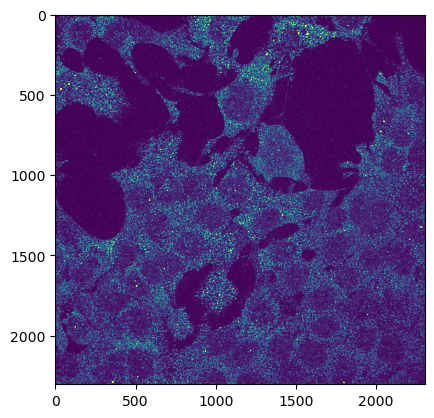

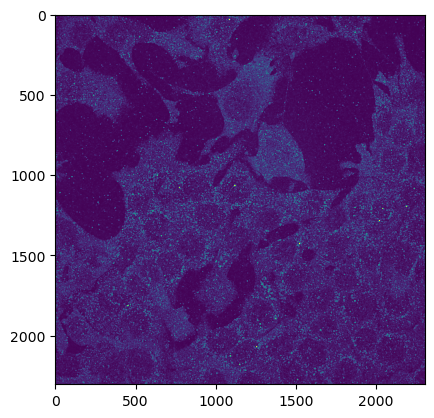

In [21]:
%matplotlib inline
plt.figure()
plt.imshow(hp_cy5.max(0), vmax=1000 )
plt.show()
plt.figure()
plt.imshow(hp_cy3.max(0), vmax=800 )
plt.show()

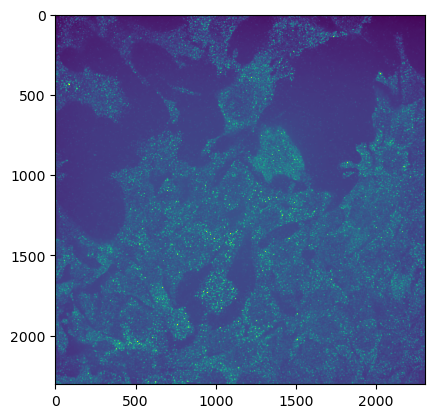

In [22]:
%matplotlib inline
plt.figure()
plt.imshow(test_im[np.array([0,3,6,9])].max(0), vmax=2000)
plt.show()

In [167]:
data_organization_filename

'/Users/puzheng/Documents/MERFISH/Weissman_MERFISH_Scripts/merlin_parameters/dataorganization/Nikon_data_organization.csv'